In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import torch.optim as optim
from torch.autograd import Variable
from time import time

from skimage.io import imread
from skimage.color import rgb2gray
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torchvision.datasets as datasets
import skimage.io as io
from skimage import transform
from skimage.transform import resize, rotate, EuclideanTransform
import numpy as np

from unet import *
from smokestack import *

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


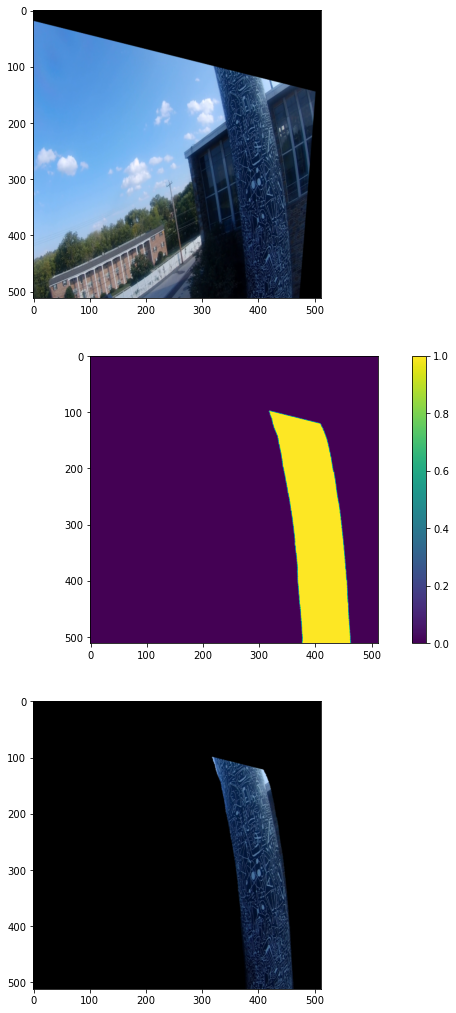

In [3]:
I = imread("Drone/Masks/0.png")
Mask = imread("Drone/Masks/0Mask.png")
Mask = Mask[:, :, 0:3]
I, Mask = get_random_transform(I, Mask, np.pi/8, 200)

sz = (512, 512)
I = resize(I, sz)
Mask = resize(Mask, sz)

plt.figure(figsize=(12, 18))
plt.subplot(311)
plt.imshow(I)
plt.subplot(312)
plt.imshow(Mask)
plt.colorbar()
plt.subplot(313)
plt.imshow(Mask[:, :, None]*I)

In [4]:
X, Y = get_data(0, 70, n_augment=4)

......................................................................

In [8]:
def train(model, opt, loss_fn, epochs, data_loader, print_status):
    loss_ls = []
    epoch_ls = []
    for epoch in range(epochs):
        tic = time()
        avg_loss = 0
        model.train() 
        b=0
        for X_batch, Y_batch in data_loader:           
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
         
            # set parameter gradients to zero
            opt.zero_grad()
            # forward pass
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            Y_batch[1] = Y_pred[1]
            loss = loss_fn(Y_pred, Y_batch)  # compute loss
            loss.backward()  # backward-pass to compute gradients
            opt.step()  # update weights

            # Compute average epoch loss
            avg_loss += loss / len(data_loader)
            b=b+1
        loss_ls.append(avg_loss)
        epoch_ls.append(epoch)
        print(loss_ls)
        print(epoch_ls)
        # Delete unnecessary tensors
        Y_batch[5:] = 0
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_batch.to(device))).detach().cpu()
        # del X_batch
        Y_hat[5:, 0] = 0
        clear_output(wait=True)
        
        print("Elapsed TIme: %.3g"%(time()-tic))
        
        for k in range(4):
            plt.subplot(3, 4, k+1)
            Y_batch2 = Variable(Y_batch[k,0,:,:], requires_grad=False)
            plt.imshow(Y_batch2.cpu().numpy(), cmap='Greys')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='Greys')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        #plt.plot(epoch_ls, loss_ls, label='traning loss')
        #plt.legend()
        #plt.xlabel('Epoch'), plt.ylabel('Loss')
        #plt.show()

    return model

In [9]:
batch_size = 4
dataloader2 = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=True)
print(X[0].shape, Y[0].shape)

(3, 512, 512) (512, 512)


In [ ]:
# Predefine input size 
n_channels = 3
n_classes = 2
# Next creat an instance of the UNet model
modelUnet = UNet().to(device)

criterion = torch.nn.BCEWithLogitsLoss()

# Now define the optimizer
optimizerUnet = optim.Adam(modelUnet.parameters(), lr = 0.000001, weight_decay=1e-2)

# And finally lets train the model
# model_out = train(modelUnet, optimizerUnet, focal_loss, 100, dataloader2, print_status=True)
model_out = train(modelUnet, optimizerUnet, criterion, 80, dataloader2, print_status=True)

In [ ]:
X_batch, Y_batch = next(iter(dataloader2))
model_out.eval()  # testing mode
Y_hat = F.sigmoid(model_out(X_batch.to(device))).detach().cpu()